In [1]:
from experiments.exp_3d.preprocessing import *
from losses.Metrics import metric_dice

from lib.visualize import display_instance
from experiments.exp_3d.inference import Pipeline

import matplotlib.pyplot as plt
import pandas as pd 


import pydicom
import pydicom_seg
import SimpleITK as sitk

In [2]:
target_size = (128, 128, 256)
target_spacing = (4.0, 4.0, 4.0)
target_direction = (1,0,0,0,1,0,0,0,1)
model_path = '/media/deeplearning/LACIE SHARE/RUDY_WEIGTH/training/20201125-17_00_45/trained_model_20201125-17_00_45.h5'
target_origin = None
from_pp = False

csv_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/inference.csv'


df = pd.read_csv(csv_path)
dataset = df[['study_id', 'ct_img', 'pet_img']].to_dict('records')
print(dataset)
print("")
pipeline = Pipeline(target_size, target_spacing, target_direction, model_path=model_path, target_origin=None, from_pp=False)
print("Pipeline object initialized")

[{'study_id': '1.2.250.1.59.453.859.92444169.1516.1370594209.2.1.1', 'ct_img': '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.1.1_nifti_CT.nii', 'pet_img': '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.1.1_nifti_PT.nii'}]

Pipeline object initialized


(263, 256, 256)
<class 'SimpleITK.SimpleITK.Image'>
(263, 256, 256)


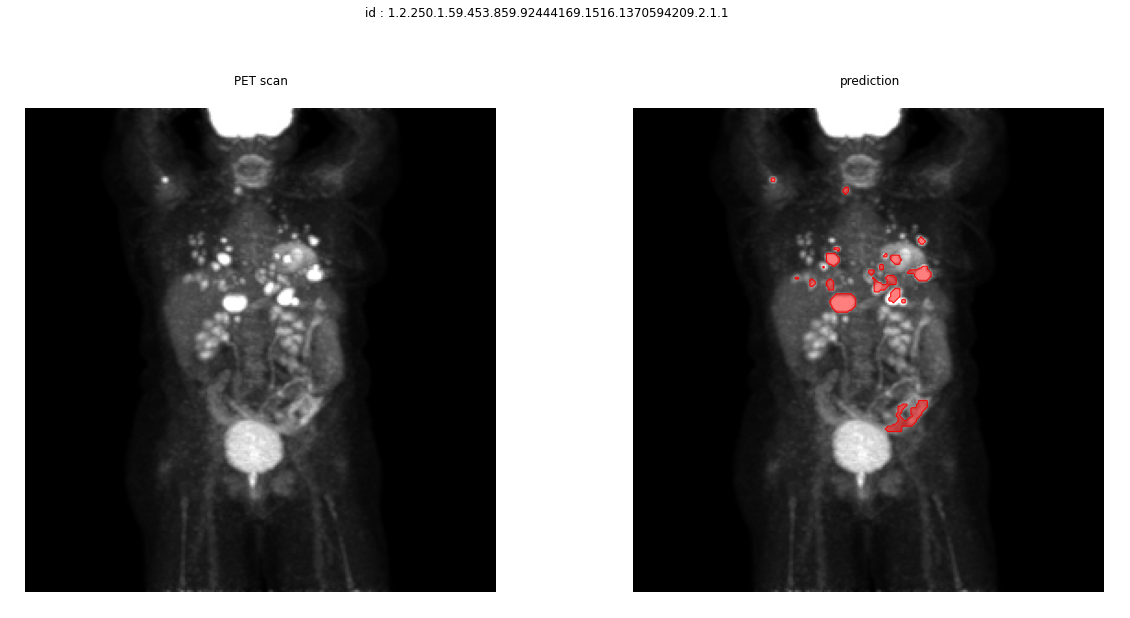

In [3]:
for count, img_path in enumerate(dataset) : 
    study_uid = img_path['study_id']
    pet_img = sitk.ReadImage(img_path['pet_img'], sitk.sitkFloat32)
    pet_spacing = pet_img.GetSpacing()
    pet_size = pet_img.GetSize()
    pet_origin = pet_img.GetOrigin()
    pet_direction = pet_img.GetDirection()
    pet_array = np.rot90(sitk.GetArrayFromImage(pet_img),2)
    print(pet_array.shape)

    axis = 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle("id : {}".format(study_uid))
    display_instance(pet_array, mask_array=None, axis=axis, ax=ax1)
    ax1.set_title('PET scan')
    
    
    pred_nifti = pipeline(img_path)
    print(str(type(pred_nifti)))
    pred = np.rot90(sitk.GetArrayFromImage(pred_nifti),2)
    print(pred.shape)
    display_instance(pet_array, mask_array=pred, axis=axis, ax=ax2)
    ax2.set_title('prediction')


### Generate DICOM-SEG

In [11]:
segmentation = pred_nifti
pet_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.2.8'
dicom_file = os.listdir(pet_path)

dicom_series_paths = [os.path.join(pet_path, x) for x in dicom_file]
source_images = [
    pydicom.dcmread(x, stop_before_pixels=True)
    for x in dicom_series_paths
]

json_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/Session1.json'
template = pydicom_seg.template.from_dcmqi_metainfo(json_path)

writer = pydicom_seg.MultiClassWriter(
    template=template,
    inplane_cropping=False,  # Crop image slices to the minimum bounding box on
                             # x and y axes. Maybe not supported by other frameworks.
    skip_empty_slices=True,  # Don't encode slices with only zeros
    skip_missing_segment=False,  # If a segment definition is missing in the
                                 # template, then raise an error instead of
                                 # skipping it.
)

dcm = writer.write(segmentation, source_images)
dcm.save_as(os.path.join('/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome','prediction_dicom_seg.dcm'))

In [9]:
name = str(input('Enter filename (filename or None):'))
while not name : 
    name = str(input('Enter filename (filename or None):'))

### - Generate nifti 

In [ ]:
#generate nifti 

img = sitk.GetImageFromArray(np.transpose(pred, (1,2,0)))
img.SetSpacing(pet_spacing)
img.SetOrigin(pet_origin)
img.SetDirection(pet_direction)

directory = ''
filename = directory + '/'+ 'nifti_mask_prediction.nii'
sitk.WriteImage(img, filename)

### - Generate RTStruct file 

In [ ]:
#generate rtss 

In [ ]:
from library_dicom.rtss_processor.model.RTSS_Writer import RTSS_Writer

#dictionnary with parameters : dataset 
dataset = {}
dataset['Description'] = 'RTStruct prediction '
roi = {}
roi['ROIName'] = 'Pred'
roi['ROIGenerationAlgorithm'] = 'SEMIAUTOMATIC'
dataset[1] = roi 
print(dataset)


#transformation to put mask on pet 
transpose = np.flip(np.rot90(np.flip(np.transpose(pred, (1,2,0)), axis=2), k=2, axes=((0,1))), axis = 1)
mask_4D = np.expand_dims(transpose, axis=-1)
mask_4D.shape

#generate rtstruct file 
pet_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.2.8'
ct_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/'
new_rtss = RTSS_Writer(mask_4D, pet_path, dataset)

filename = 'rtss_prediction_mask_pet_v3.dcm'
directory_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome'
new_rtss.save_file(filename, directory_path)